## Carregando dados

In [1]:
# import necessary libraries
from tqdm import tqdm

from time import sleep
import numpy as np
import re
from matplotlib import pyplot as plt

import seaborn as sns

import tensorflow_hub as hub
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, Bidirectional
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
!gdown --id 1mZfnBPCPSV0ZjVClLYZoxHzacZZxU5ZG

Downloading...
From: https://drive.google.com/uc?id=1mZfnBPCPSV0ZjVClLYZoxHzacZZxU5ZG
To: /content/en.zip
100% 2.90M/2.90M [00:00<00:00, 210MB/s]


In [3]:
!unzip en.zip

Archive:  en.zip
  inflating: secs0-18-training       
  inflating: secs19-21-development   
  inflating: secs22-24-testing       


In [87]:
sep = '_'
X_train = []
Y_train = []
with open('secs0-18-training', 'r') as file:
    for line in file:
        X_sentence = []
        Y_sentence = []
        for pair in re.split(' ', line):
            if len(pair) > 2:
                token, tag = pair.split(sep)
                tag = tag.strip()
                X_sentence.append(token)
                Y_sentence.append(tag)
        X_train.append(X_sentence)
        Y_train.append(Y_sentence)

In [88]:
sep = '_'
X_val = []
Y_val = []
with open('secs19-21-development', 'r') as file:
    for line in file:
        X_sentence = []
        Y_sentence = []
        for pair in re.split(' ', line):
            if len(pair) > 2:
                token, tag = pair.split(sep)
                tag = tag.strip()
                X_sentence.append(token)
                Y_sentence.append(tag)
        X_val.append(X_sentence)
        Y_val.append(Y_sentence)

In [89]:
sep = '_'
X_test = []
Y_test = []
with open('secs22-24-testing', 'r') as file:
    for line in file:
        X_sentence = []
        Y_sentence = []
        for pair in re.split(' ', line):
            if len(pair) > 2:
                token, tag = pair.split(sep)
                tag = tag.strip()
                X_sentence.append(token)
                Y_sentence.append(tag)
        X_test.append(X_sentence)
        Y_test.append(Y_sentence)

## Preprocessamento dos dados

In [90]:
train_vocabulary = set([word.lower() for sentence in X_train for word in sentence])

full_vocabulary = len(train_vocabulary.union(set([word.lower() for sentence in X_val for word in sentence])).union(set([word.lower() for sentence in X_test for word in sentence])))

num_tags  = len(set([word.lower() for sentence in Y_train for word in sentence]))

In [91]:
print("Quantidade de sentenças de treino: {}".format(len(X_train)))
print("Quantidade de sentenças de validação: {}".format(len(X_val)))
print("Quantidade de sentenças de teste: {}".format(len(X_test)))
print()
print("Tamanho do vocabulario extraido do treino: {}".format(len(train_vocabulary)))
print("Tamanho do vocabulario total dos dados: {}".format(full_vocabulary))
print("Quantidade de tags possiveis: {}".format(num_tags))

Quantidade de sentenças de treino: 38219
Quantidade de sentenças de validação: 5527
Quantidade de sentenças de teste: 5462

Tamanho do vocabulario extraido do treino: 38574
Tamanho do vocabulario total dos dados: 43766
Quantidade de tags possiveis: 45


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


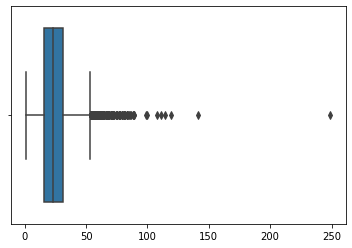

In [92]:
sns.boxplot([len(sentence) for sentence in X_train])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


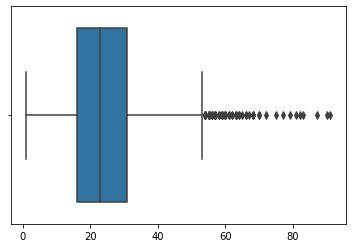

In [93]:
sns.boxplot([len(sentence) for sentence in X_val])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


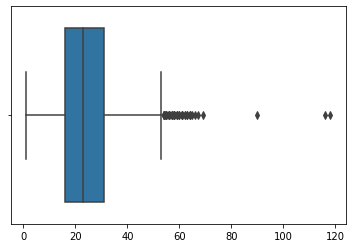

In [94]:
sns.boxplot([len(sentence) for sentence in X_test])
plt.show()

In [95]:
max_len = 100

X_train = [x for x in X_train if len(x) <= max_len]
Y_train = [y for y in Y_train if len(y) <= max_len]

X_val = [x for x in X_val if len(x) <= max_len]
Y_val = [y for y in Y_val if len(y) <= max_len]

X_test = [x for x in X_test if len(x) <= max_len]
Y_test = [y for y in Y_test if len(y) <= max_len]

In [96]:
word_tokenizer = Tokenizer(filters="", oov_token="<unk>")
word_tokenizer.fit_on_texts(X_train)

# word_tokenizer.fit_on_texts(X_val)
# word_tokenizer.fit_on_texts(X_test)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [97]:
tag_tokenizer = Tokenizer(filters="")
tag_tokenizer.fit_on_texts(Y_train)

# tag_tokenizer.fit_on_texts(Y_val)
# tag_tokenizer.fit_on_texts(Y_test)

Y_train = tag_tokenizer.texts_to_sequences(Y_train)
Y_val = tag_tokenizer.texts_to_sequences(Y_val)
Y_test = tag_tokenizer.texts_to_sequences(Y_test)

In [98]:
padding_value = 0
X_train = pad_sequences(X_train, maxlen=max_len, padding="post", truncating="post", value=padding_value)
Y_train = pad_sequences(Y_train, maxlen=max_len, padding="post", truncating="post", value=padding_value)

X_val = pad_sequences(X_val, maxlen=max_len, padding="post", truncating="post", value=padding_value)
Y_val = pad_sequences(Y_val, maxlen=max_len, padding="post", truncating="post", value=padding_value)

X_test = pad_sequences(Y_test, maxlen=max_len, padding="post", truncating="post", value=padding_value)
Y_test = pad_sequences(Y_test, maxlen=max_len, padding="post", truncating="post", value=padding_value)

In [99]:
num_classes = len(tag_tokenizer.word_index)+1
Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_val = to_categorical(Y_val, num_classes=num_classes)
Y_test = to_categorical(Y_test, num_classes=num_classes)

## Embeddings

In [100]:
url = "https://tfhub.dev/google/nnlm-en-dim50/2"
# url = "https://tfhub.dev/google/Wiki-words-500-with-normalization/2"

In [101]:
encoder = hub.load(url)

In [102]:
EMBEDDING_SIZE  = encoder.embeddings.shape[1]
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

embedding_weights = np.random.rand(VOCABULARY_SIZE, EMBEDDING_SIZE)
words_idx = word_tokenizer.word_index.items()
embedding_weights[[w[1] for w in words_idx], :] = encoder([w[0] for w in words_idx])

## Dados finais para treino, validação e teste

In [103]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_val.shape))
print('Shape of output sequences: {}'.format(Y_val.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (38213, 100)
Shape of output sequences: (38213, 100, 46)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (5527, 100)
Shape of output sequences: (5527, 100, 46)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (5460, 100)
Shape of output sequences: (5460, 100, 46)


# 3. Modelo LSTM Bidirecional

In [126]:
NUM_CLASSES = Y_train.shape[2]
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = max_len,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(256, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
# bidirect_model.add(Dense(NUM_CLASSES, activation='softmax'))

In [127]:
bidirect_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="Accuracy"), tf.keras.metrics.Precision(name="Precision"), tf.keras.metrics.Recall(name="Recall")])

In [128]:
bidirect_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 50)           1926250   
                                                                 
 bidirectional_8 (Bidirectio  (None, 100, 512)         628736    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 100, 46)          23598     
 tributed)                                                       
                                                                 
Total params: 2,578,584
Trainable params: 2,578,584
Non-trainable params: 0
_________________________________________________________________


In [129]:
%%time
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=32, epochs=5, validation_data=(X_val, Y_val))

Epoch 1/5
1195/1195 [==============================] - 98s 65ms/step - loss: 0.3993 - Accuracy: 0.8975 - Precision: 0.9939 - Recall: 0.8451 - val_loss: 0.1446 - val_Accuracy: 0.9628 - val_Precision: 0.9857 - val_Recall: 0.9427
Epoch 2/5
1195/1195 [==============================] - 76s 64ms/step - loss: 0.0908 - Accuracy: 0.9753 - Precision: 0.9884 - Recall: 0.9634 - val_loss: 0.0774 - val_Accuracy: 0.9790 - val_Precision: 0.9868 - val_Recall: 0.9726
Epoch 3/5
1195/1195 [==============================] - 77s 64ms/step - loss: 0.0554 - Accuracy: 0.9837 - Precision: 0.9889 - Recall: 0.9792 - val_loss: 0.0631 - val_Accuracy: 0.9831 - val_Precision: 0.9870 - val_Recall: 0.9799
Epoch 4/5
1195/1195 [==============================] - 76s 64ms/step - loss: 0.0447 - Accuracy: 0.9863 - Precision: 0.9897 - Recall: 0.9836 - val_loss: 0.0592 - val_Accuracy: 0.9842 - val_Precision: 0.9873 - val_Recall: 0.9819
Epoch 5/5
1195/1195 [==============================] - 77s 65ms/step - loss: 0.0392 - Accura

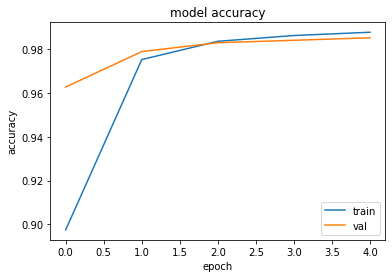

In [130]:
# visualise training history
plt.plot(bidirect_training.history['Accuracy'])
plt.plot(bidirect_training.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

In [142]:
tags = ['pad']+[ti[0] for ti in tag_tokenizer.word_index.items()]
index = [0]+[ti[1] for ti in tag_tokenizer.word_index.items()]

In [148]:
Y_pred = bidirect_model.predict(X_train, verbose = 1)
print(classification_report(np.argmax(Y_train, axis=2).reshape(-1), np.argmax(Y_pred, axis=2).reshape(-1), labels=np.array(index), target_names=np.array(tags)))

1195/1195 [==============================] - 22s 18ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         pad       1.00      1.00      1.00   2909798
          nn       0.92      0.95      0.94    127484
          in       0.99      0.98      0.98     94712
         nnp       0.90      0.90      0.90     87481
          dt       0.99      0.99      0.99     78737
          jj       0.90      0.86      0.88     58910
         nns       0.96      0.97      0.97     57836
           ,       1.00      1.00      1.00     46409
           .       1.00      1.00      1.00     37873
          cd       0.95      0.97      0.96     34846
          rb       0.90      0.94      0.92     29612
         vbd       0.93      0.97      0.95     28304
          vb       0.96      0.96      0.96     25477
          cc       1.00      0.99      1.00     22798
          to       1.00      1.00      1.00     21452
         vbz       0.96      0.97      0.97     20978
         vbn       0.90      0.88      0.89     19316
         prp       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [147]:
Y_pred = bidirect_model.predict(X_val, verbose = 1)
print(classification_report(np.argmax(Y_val, axis=2).reshape(-1), np.argmax(Y_pred, axis=2).reshape(-1), labels=np.array(index), target_names=np.array(tags)))

173/173 [==============================] - 4s 21ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         pad       1.00      1.00      1.00    420932
          nn       0.92      0.91      0.92     18538
          in       0.99      0.97      0.98     13651
         nnp       0.82      0.90      0.86     13183
          dt       0.99      0.99      0.99     11230
          jj       0.87      0.82      0.84      8094
         nns       0.97      0.93      0.95      8043
           ,       1.00      1.00      1.00      7087
           .       1.00      1.00      1.00      5468
          cd       0.91      0.96      0.94      5223
          rb       0.88      0.92      0.90      4171
         vbd       0.93      0.97      0.95      4621
          vb       0.95      0.94      0.95      3503
          cc       1.00      0.99      0.99      3380
          to       1.00      1.00      1.00      3074
         vbz       0.96      0.95      0.95      2815
         vbn       0.90      0.84      0.87      2825
         prp       0.99    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [149]:
Y_pred = bidirect_model.predict(X_test, verbose = 1)
print(classification_report(np.argmax(Y_test, axis=2).reshape(-1), np.argmax(Y_pred, axis=2).reshape(-1), labels=np.array(index), target_names=np.array(tags)))

171/171 [==============================] - 3s 19ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         pad       1.00      1.00      1.00    416580
          nn       0.00      0.00      0.00     17792
          in       0.00      0.00      0.00     13472
         nnp       0.00      0.00      0.00     13145
          dt       0.00      0.00      0.00     11162
          jj       0.00      0.00      0.00      8198
         nns       0.00      0.00      0.00      8047
           ,       0.00      0.00      0.00      6865
           .       0.00      0.00      0.00      5379
          cd       0.00      0.00      0.00      4816
          rb       0.00      0.00      0.00      4401
         vbd       0.00      0.00      0.00      4560
          vb       0.00      0.00      0.00      3563
          cc       0.00      0.00      0.00      3239
          to       0.00      0.00      0.00      2905
         vbz       0.00      0.00      0.00      2639
         vbn       0.00      0.00      0.00      2707
         prp       0.87    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
loss, accuracy, precision, recall = bidirect_model.evaluate(X_train, Y_train, verbose = 1)
print("Loss: {0}\nAccuracy: {1}\nPrecision: {2}\nRecall: {3}".format(loss, accuracy, precision, recall))

1195/1195 [==============================] - 51s 42ms/step - loss: 0.0167 - Accuracy: 0.9943 - Precision: 0.9950 - Recall: 0.9937
Loss: 0.01665431261062622
Accuracy: 0.9942862391471863
Precision: 0.9950199723243713
Recall: 0.9937044978141785


In [151]:
loss, accuracy, precision, recall = bidirect_model.evaluate(X_val, Y_val, verbose = 1)
print("Loss: {0}\nAccuracy: {1}\nPrecision: {2}\nRecall: {3}".format(loss, accuracy, precision, recall))

173/173 [==============================] - 5s 29ms/step - loss: 0.0549 - Accuracy: 0.9853 - Precision: 0.9880 - Recall: 0.9835
Loss: 0.054878704249858856
Accuracy: 0.9853103160858154
Precision: 0.9880075454711914
Recall: 0.9835028052330017


In [150]:
loss, accuracy, precision, recall = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0}\nAccuracy: {1}\nPrecision: {2}\nRecall: {3}".format(loss, accuracy, precision, recall))

171/171 [==============================] - 5s 29ms/step - loss: 2.8449 - Accuracy: 0.7670 - Precision: 0.7701 - Recall: 0.7670
Loss: 2.844879150390625
Accuracy: 0.7670018076896667
Precision: 0.7701473236083984
Recall: 0.7670018076896667
